<IPython.core.display.Javascript object>


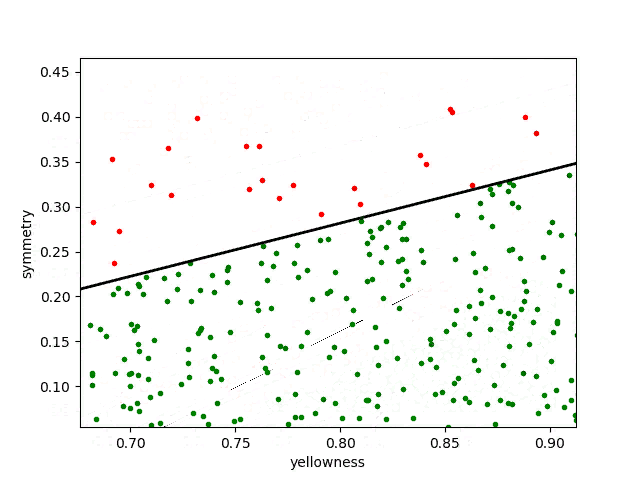

In [2]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3
import numpy as np
import random
import time

from functools import partial
from ipywidgets import interact, RadioButtons, IntSlider, FloatSlider, Dropdown, BoundedFloatText
from numpy.linalg import norm

random.seed(42) # начальное состояние генератора случайных чисел, чтобы можно было воспроизводить результаты.

class Perceptron:

    def __init__(self, w, b):
        
        """
        Инициализируем наш объект - перцептрон.
        w - вектор весов размера (m, 1), где m - количество переменных
        b - число
        """
        self.w = w
        self.b = b
        
    
    def forward_pass(self, single_input):
        """
        Метод рассчитывает ответ перцептрона при предъявлении одного примера
        single_input - вектор примера размера (m, 1).
        Метод возвращает число (0 или 1) или boolean (True/False)
        """
        
        result = 0
        for i in range(0, len(self.w)):
            result += self.w[i] * single_input[i]
        result += self.b
        
        if result > 0:
            return 1
        else:
            return 0
    
    
    
    
    
    '''def vectorized_forward_pass(self, input_matrix):
        out = input_matrix.dot(self.w)
        out += self.b
        is_positive = out > 0
        return is_positive'''
    
    '''def vectorized_forward_pass(self, input_matrix):        
        return input_matrix.dot(self.w) > -self.b'''
    
    '''vectorized_forward_pass = lambda p, x: x @ p.w > -p.b'''
    
    def vectorized_forward_pass(self, input_matrix):
        """
        Метод рассчитывает ответ перцептрона при предъявлении набора примеров
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных
        Возвращает вертикальный вектор размера (n, 1) с ответами перцептрона
        (элементы вектора - boolean или целые числа (0 или 1))
        """
        return (input_matrix.dot(self.w) + self.b) > 0

    
    
    
    
    '''def train_on_single_example(self, example, y):
    self.w, self.b = (x[0] + (y-self.vectorized_forward_pass(example.T)[0][0])*x[1] for x in ((self.w, example), (self.b,1)))'''
    
    '''def train_on_single_example(self, example, y):
    self.w, self.b = (x[0] + (y-self.forward_pass(example))*x[1] for x in ((self.w, example), (self.b,1)))'''
    
    def train_on_single_example(self, example, y):
        """
        принимает вектор активации входов example формы (m, 1) 
        и правильный ответ для него (число 0 или 1 или boolean),
        обновляет значения весов перцептрона в соответствии с этим примером
        и возвращает размер ошибки, которая случилась на этом примере до изменения весов (0 или 1)
        (на её основании мы потом построим интересный график)
        """
        dif = int(y - self.vectorized_forward_pass(example.T))
        self.w = self.w + (dif * example)
        self.b += dif
        
        return dif
    
    def train_until_convergence(self, input_matrix, y, max_steps=1e8):
        """
        input_matrix - матрица входов размера (n, m),
        y - вектор правильных ответов размера (n, 1) (y[i] - правильный ответ на пример input_matrix[i]),
        max_steps - максимальное количество шагов.
        Применяем train_on_single_example, пока не перестанем ошибаться или до умопомрачения.
        Константа max_steps - наше понимание того, что считать умопомрачением.
        """
        i = 0
        errors = 1
        while errors and i < max_steps:
            i +=1
            errors = 0
            for example, answer in zip(input_matrix, y):
                example = example.reshape((example.size, 1))
                error = self.train_on_single_example(example, answer)
                errors += int(error) # int(True) = 1, int(False) = 0, так что можно не делать if

def create_perceptron(m):
    """Создаём перцептрон со случайными весами и m входами"""
    w = np.random.random((m, 1))
    return Perceptron(w, 1)

                
def plot_line(coefs):
    """
    рисует разделяющую прямую, соответствующую весам, переданным в coefs = (weights, bias), 
    где weights - ndarray формы (2, 1), bias - число
    """
    w, bias = coefs
    a, b = - w[0][0] / w[1][0], - bias / w[1][0]
    xx = np.linspace(*plt.xlim())
    line.set_data(xx, a*xx + b)
    
    
def step_by_step_weights(p, input_matrix, y, max_steps=1e6):
    """
    обучает перцептрон последовательно на каждой строчке входных данных, 
    возвращает обновлённые веса при каждом их изменении
    p - объект класса Perceptron
    """
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            
            error = p.train_on_single_example(example, answer)
            errors += error  # здесь мы упадём, если вы забыли вернуть размер ошибки из train_on_single_example
            if error:  # будем обновлять положение линии только тогда, когда она изменила своё положение
                yield p.w, p.b
                
    for _ in range(20): yield p.w, p.b
        

        
%matplotlib nbagg

data = np.loadtxt("data.csv", delimiter=",")
pears = data[:, 2] == 1
apples = np.logical_not(pears)
np.random.seed(1)
fig = plt.figure()
plt.scatter(data[apples][:, 0], data[apples][:, 1], color = "red", marker=".", label="Apples")
plt.scatter(data[pears][:, 0], data[pears][:, 1], color = "green", marker=".", label="Pears")
plt.xlabel("yellowness")
plt.ylabel("symmetry")
line, = plt.plot([], [], color="black", linewidth=2)  # создаём линию, которая будет показывать границу разделения

from matplotlib.animation import FuncAnimation

perceptron_for_weights_line = create_perceptron(2)  # создаём перцептрон нужной размерности со случайными весами

from functools import partial
weights_ani = partial(
    step_by_step_weights, p=perceptron_for_weights_line, input_matrix=data[:, :-1], y=data[:, -1][:,np.newaxis]
)  # про partial почитайте на https://docs.python.org/3/library/functools.html#functools.partial

ani = FuncAnimation(fig, func=plot_line, frames=weights_ani, blit=False, interval=10, repeat=True)
# если Jupyter не показывает вам анимацию - раскомментируйте строчку ниже и посмотрите видео
# ani.save("perceptron_seeking_for_solution.mp4", fps=15)
plt.show()

## Не забудьте остановить генерацию новых картинок, прежде чем идти дальше (кнопка "выключить" в правом верхнем углу графика)
